Importing Modules


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 
import requests


In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

Reading the url


In [4]:
url_data = pd.read_html(url) # list with first element as a dataframe containing the table

In [19]:
table=url_data[0] #data frame containing the table in the Wikipedia page
table=table.dropna() #droping rows withn na values
table=table.reset_index()
table=table.drop(['index'],axis=1)

Changing words seperated by slash ('/') to words seperated by comma (,)

In [20]:
# A function to change neighbourhoods seperaed by '/' to neighbourhoods seperated by comma
def slashToComma(string):
    split=string.split('/')
    if len(split)>1:
        w=(',').join(split)
        return w
      
    else:
         return string

Applying the function to the dataframe table

In [21]:
table['Neighborhood']=table['Neighborhood'].apply(lambda x: slashToComma(x))
table.head(10)

,Postal code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government"
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern , Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill , Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [22]:
table.shape

(103, 3)

Reading csv file stored in my computer containing the geospatial data

In [23]:
locationData=pd.read_csv(r'C:\Users\Sudeep\Dropbox\Online Classes\Data Science Course\Capstone Project\Geospatial_Coordinates.csv')
locationData=locationData.set_index(['Postal Code'])

Getting the latitude and longitude from 'locationData' of postal codes in 'table' 

In [24]:
mask=table['Postal code']
latLongData=locationData.loc[mask]
latLongData=latLongData.reset_index()

In [26]:
table['Latitude']=latLongData['Latitude']
table['Longitude']=latLongData['Longitude']
table.head(10)

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill , Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [27]:
table.shape

(103, 5)

In [28]:
#getting data only for Brough named Toronto
mask2=np.array(['Toronto' in p for p in table['Borough']])
TorontoData=table.loc[mask2]
TorontoData=TorontoData.reset_index()
TorontoData=TorontoData.drop(['index'],axis=1)

Getting venu names in Toronto along with their catagory.

In [31]:
#Getting venus with their category
CLIENT_ID = '2VJ2GRSI0CC0IIFLJLU1REFSOHKV01X5BQCORQC0YLSXNUT1' # your Foursquare ID
CLIENT_SECRET = '445JKD5IYV05AFKJLJNP1YZFVACV2QUAQA1ZS2YRPJW0J0DJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#function to get nearby venus with their category
def getNearbyVenues(names, latitudes, longitudes,LIMIT=100,radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
    
Toronto_venues = getNearbyVenues(names=TorontoData['Neighborhood'],latitudes=TorontoData['Latitude'],longitudes=TorontoData['Longitude'])

Preparing data for clustering

In [32]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")
# adding neighborhood column back to the dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 
# moving neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot =Toronto_onehot[fixed_columns]

#Grouping rows by neighborhood and taking the mean of the frequency of occurrence of each category
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [34]:
#most common venus
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
###############################################################################
#Not important??
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
###############################################################################
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)
Toronto_grouped_clustering =Toronto_grouped.drop('Neighborhood', 1)    

Finding the best value for the number of clusters by 'elbow method'

Text(0, 0.5, 'Inertia')

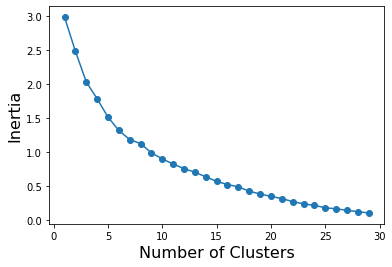

In [35]:
inertia=[]
counter=[]
dis=[]
from scipy.spatial.distance import cdist 
for kclusters in range(1,30):

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)
    inertia.append(kmeans.inertia_)
    dis.append(sum(np.min(cdist(Toronto_grouped_clustering, kmeans.cluster_centers_,'euclidean'),axis=1)) / Toronto_grouped_clustering.shape[0])  
    counter.append(kclusters)
plt.figure(1)
plt.scatter(counter,inertia)
plt.plot(counter,inertia)
plt.xlabel('Number of Clusters',fontsize=16)
plt.ylabel('Inertia',fontsize=16)

The elbow is not so prominent, I took number of clusters=9 

Fitting KMeans with the best value of K=9

In [36]:
kclusters=9
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = TorontoData

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')



Creating cluster map

In [38]:
address = 'Toronto'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

In [40]:
map_clusters